Identificación de sistemas usando ADALINEs
===

* *90 min* | Última modificación: Marzo 21, 2020.

## Definición del problema

Cuando un sistema desconocido es excitado mediante una señal de entrada $z(k)$ se produce una señal de salida $d(k)$. El diagrama del sistema aparece en la figura de abajo. Para efectos de control se requiere un modelo que permita pronosticar el valor de $d(k)$ a partir del valor actual y los valores pasados de la señal de entrada $z(k)$, $z(k-1)$, $z(k-2)$, ... El diagrama ilustrativo es presentado a continuación.



![assets/AdalineIdentificacion-01.png](assets/AdalineIdentificacion-01.png)

En este tipo de problemas no es posible modelar el sistema que genera la señal de salida $d(t)$. Adicionalmente, la señal está contaminada con ruído por lo que resulta imposible pronosticarla de forma perfecta. Por facilidad se supondra que la dinámica del sistema desconocido es descrita por siguiente ecuación no lineal:

$$d_t = 0.4 + 0.1 z_{t} + 0.9 z_{t-1} - 0.6 z_{t-2} - 0.2 z_{t-1}^2 + u_t$$

donde $u_t$ es una variable aleatoria normal con $\mu=0$ y $\sigma = 0.05$.  $z_t$ es una variable aleatoria uniforme en el intervalo $[0,1]$. A continuación se generan las series.

El problema propuesto es conocido como un problema de identificación de sistemas, donde un modelo adaptativo (una red neuronal en este caso) debe aproximar el comportamiento real (la salida, $d_t$) de un sistema desconocido a partir de un conjunto de entradas (el vector $\mathbf{x}_t$) conocidas. El diagrama esquemático del sistema es el siguiente: 

![assets/AdalineIdentificacion-02.png](assets/AdalineIdentificacion-02.png)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
%matplotlib inline

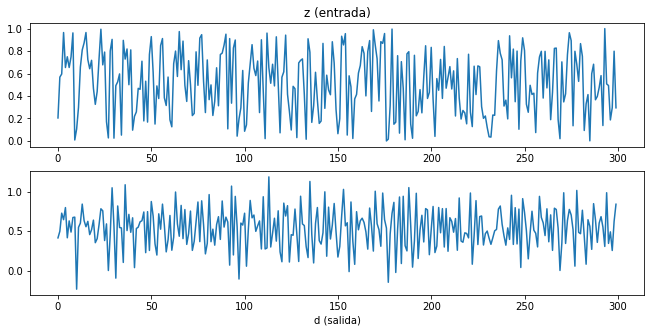

In [2]:
np.random.seed(12345)
z = np.random.uniform(size=303)
d = 0.05 * np.random.standard_normal(303)

L = 2

for t in range(2, 303):
    d[t] = d[t] + 0.4 + 0.1 * z[t] + 0.9 * z[t-1] - 0.6 * z[t-2] - 0.2 * z[t-1]**2  
    
d = d[3:303]
z = z[3:303]

plt.figure(figsize=(11,5))
plt.subplot(2, 1, 1)
plt.plot(z)
plt.title('z (entrada)')
plt.subplot(2, 1, 2)
plt.plot(d);
plt.xlabel('d (salida)');

En términos de los datos se requiere construir un modelo de regresión que permita pronosticar $d_t$ a partir de los valores $z_t$, $z_{t-1}$, ...

## Solución

En el caso del problema planteado, el pronóstico se realiza usando el siguiente sistema adaptativo de lazo cerrado, en el cual, el modelo adaptativo es un ADALINE.

![assets/AdalinePronostico-06.png](assets/AdalinePronostico-06.png)

In [3]:
class Adaline:
    def __init__(self, 
                 learning_rate=0.001, # tasa de aprendizaje
                 max_epochs=100,      # número máximo de iteraciones sobre el set de datos
                 shuffle=False,       # mezcla patrones para aprendizaje online
                 random_state=None,   #
                 warm_start=False):   #
        
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.shuffle = shuffle
        self.random_state = random_state
        self.warm_start = warm_start
        self.coef_ = None
        self.intercept_ = None
        
    def fit(self, X, y):
        
        if not isinstance(X, np.ndarray):
            X = np.array(X)
        if not isinstance(y, np.ndarray):
            d = np.array(y)
        else:
            d = y.copy()
            
        if self.random_state is not None:
            np.random.RandomState(self.random_state)

        if self.coef_ is None or self.warm_start is False:
            self.coef_ = np.random.uniform(-1, 1, X.shape[1])
            
        if self.intercept_ is None  or self.warm_start is False:
            self.intercept_ = np.random.uniform(-1, 1, 1)

        errors2 = []  
        forecasts = []
        
        for epoch in range(self.max_epochs):

            if self.shuffle is True:
                n = list(range(X.shape[0]))
                np.random.shuffle(n)
                X = X[n,:]
                d = d[n]

            for i in range(X.shape[0]):
                u = np.dot(X[i,:], self.coef_) + self.intercept_
                e = (d[i] - u)[0]
                self.coef_ += 2 * self.learning_rate * e * X[i,:]
                self.intercept_ += 2 * self.learning_rate * e 
                errors2.append(e**2)  
                forecasts.append(u)

        return errors2, forecasts
                    
    def predict(self, X):
        if not isinstance(X, np.ndarray):
            X = np.array(X)        
        u = np.dot(X, self.coef_) + self.intercept_
        return u

In [4]:
##
##  Para pronosticar el valor actual se toman los `L` 
##  valores previos de la serie explicativa
##
L = 5

##
## Forma la matriz X
##
X = []
for t in range(L, len(d)):
    X.append(z[t-L:t].tolist())

##
## Primeras 3 filas
##
X[0:3]

[[0.2045602785530397,
  0.5677250290816866,
  0.5955447029792516,
  0.9645145197356216,
  0.6531770968715709],
 [0.5677250290816866,
  0.5955447029792516,
  0.9645145197356216,
  0.6531770968715709,
  0.7489066375339118],
 [0.5955447029792516,
  0.9645145197356216,
  0.6531770968715709,
  0.7489066375339118,
  0.6535698708517353]]

In [5]:
#
# Especificación del modelo
#
adaline = Adaline(
    learning_rate=0.08,  # tasa de aprendizaje
    max_epochs=1,        # número máximo de iteraciones sobre el set de datos
    shuffle=False,       # mezcla patrones para aprendizaje online
    random_state=123,    # corrida reproducible
    warm_start=False)    # inicia con pesos aleatorios

In [6]:
#
# Entrenamiento
#
errors2, forecasts = adaline.fit(
    X,
    d[L:])

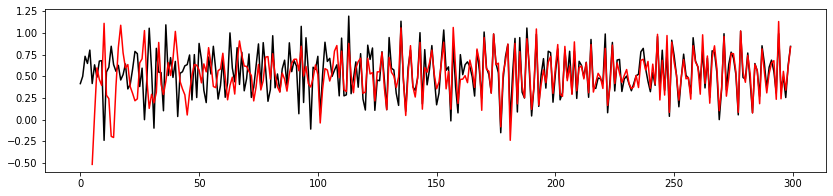

In [7]:
#
# Resultados
#
plt.figure(figsize=(14,3))
plt.plot(d, color='black');
plt.plot(range(L,len(d)), forecasts, color = 'red');

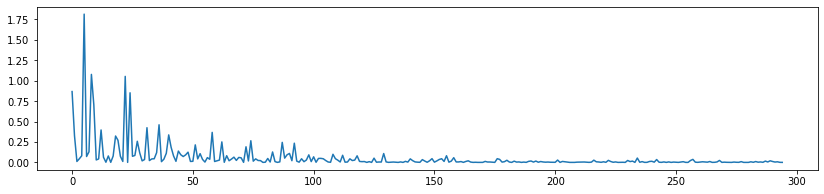

In [8]:
#
# Errores al cuadrado
#
plt.figure(figsize=(14,3))
plt.plot(errors2);